In [1]:
from __init__ import *
from src.explainAI import hedge
from src.explainAI import hedge_bert

In [2]:
from src.utils import config
from src.DL.models.bert import Model
from transformers import BertTokenizer
import torch
config.bert_path = config.root_path + '/model/bert/'
config.hidden_size = 768
model = Model(config).to(config.device)

checkpoint = torch.load(config.root_path + '/model/saved_dict/bert.ckpt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint, strict=False)
tokenizer = BertTokenizer.from_pretrained(
    config.root_path + '/model/bert', do_lower_case=config.do_lower_case)
model.to(config.device)



Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

In [3]:
from torch.utils.data import DataLoader
from src.data.dataset import MyDataset, collate_fn
if config.visualize > -1:
    start_pos = config.visualize
    end_pos = start_pos + 1
else:
    start_pos = config.start_pos
    end_pos = config.end_pos
print('load data')
test_dataset = MyDataset(config.test_file,
                         None,
                         config.max_length,
                         tokenizer=tokenizer,
                         word=False)

eval_dataloader = DataLoader(test_dataset,
                                 batch_size=config.batch_size,
                                 shuffle=True,
                                 drop_last=True,
                                 collate_fn=collate_fn)



load data


In [4]:
import itertools
batch = list(itertools.islice(eval_dataloader, start_pos, end_pos))[0]
batch = tuple(t.to(config.device) for t in batch)

In [10]:
'''
@Author: xiaoyao jiang
@LastEditors: xiaoyao jiang
@Date: 2020-07-01 17:58:38
@LastEditTime: 2020-07-06 16:46:03
@FilePath: /bookClassification/src/explainAI/hedge.py
@Desciption:  from https://github.com/UVa-NLP/HEDGE/blob/master/bert/hedge_bert.py
'''
import numpy as np
from itertools import combinations
import torch
from copy import deepcopy


class HEDGE:
    def __init__(self, model, inputs, args, max_level=-1, thre=0.3):
        score = model(inputs).detach().cpu().numpy()
        score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        self.pred_label = np.argmax(score_norm)
        self.max_level = max_level
        self.output = []
        self.fea_num = len(inputs[0][0]) - 2  # input_ids
        self.level = 0
        self.args = args
        self.thre = thre
        input = inputs[0][0]  # input_ids
        mask_input = torch.zeros(input.shape, dtype=torch.long)
        mask_attention = torch.zeros(input.shape, dtype=torch.long)
        mask_type = torch.zeros(input.shape, dtype=torch.long)
        temp = [
            torch.unsqueeze(mask_input, 0).to(args.device),  # input_ids
            torch.unsqueeze(mask_attention, 0).to(args.device),  # attention_mask
            torch.unsqueeze(mask_type, 0).to(args.device),  # token_type_ids
        ]
        score = model(temp).detach().cpu().numpy()
        score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        self.bias = score_norm[0][self.pred_label]

    def set_contribution_func(self, model, fea_set, inputs):
        # input has just one sentence, input is a list
        args = self.args
        input = inputs[0][0]  # input_ids
        mask_input = torch.zeros(input.shape, dtype=torch.long)
        mask_input[0] = input[0]
        mask_input[-1] = input[-1]
        mask_attention = torch.zeros(input.shape, dtype=torch.long)
        mask_attention[0] = 1
        mask_attention[-1] = 1
        mask_type = torch.zeros(input.shape, dtype=torch.long)

        # mask the input with zero
        for fea_idx in fea_set:
            if type(fea_idx) == int:
                mask_input[fea_idx + 1] = input[
                    fea_idx + 1]  # +1 accounts for the CLS token at the begining
                mask_attention[
                    fea_idx + 1] = 1  # +1 accounts for the CLS token at the begining
            else:
                for idx in fea_idx:
                    mask_input[idx + 1] = input[
                        idx + 1]  # +1 accounts for the CLS token at the begining
                    mask_attention[
                        idx + 1] = 1  # +1 accounts for the CLS token at the begining
        temp = [
            torch.unsqueeze(mask_input, 0).to(args.device),  # input_ids
            torch.unsqueeze(mask_attention, 0).to(args.device),  # attention_mask
            torch.unsqueeze(mask_type, 0).to(args.device),  # token_type_ids
        ]
        # send the mask_input into model
        score = model(temp).detach().cpu().numpy()
        score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))

        return score_norm[0][self.pred_label] - self.bias

    def get_shapley_interaction_weight(self, d, s):
        return np.math.factorial(s) * np.math.factorial(
            d - s - 2) / np.math.factorial(d - 1) / 2

    def shapley_interaction_score_approx(self, model, input, feature_set, left,
                                         right, win_size):
        if left + 1 != right:
            print("Not adjacent interaction")
            return -1
        fea_num = len(feature_set)
        curr_set_lr = list((feature_set[left], feature_set[right]))
        curr_set_l = [feature_set[left]] if type(
            feature_set[left]) == int else feature_set[left]
        curr_set_r = [feature_set[right]] if type(
            feature_set[right]) == int else feature_set[right]
        if left + 1 - win_size > 0:
            left_set = feature_set[left - win_size:left]
        else:
            left_set = feature_set[0:left]
        if right + win_size > fea_num - 1:
            right_set = feature_set[right + 1:]
        else:
            right_set = feature_set[right + 1: right + win_size + 1]
        adj_set = left_set + right_set
        num_adj = len(adj_set)
        dict_subset = {
            r: list(combinations(adj_set, r))
            for r in range(num_adj + 1)
        }
        score = 0.0
        for i in range(num_adj + 1):
            weight = self.get_shapley_interaction_weight(fea_num, i)
            if i == 0:
                score_included = self.set_contribution_func(
                    model, curr_set_lr, input)
                score_excluded_l = self.set_contribution_func(
                    model, curr_set_r, input)
                score_excluded_r = self.set_contribution_func(
                    model, curr_set_l, input)
                score_excluded = self.set_contribution_func(model, [], input)
                score += (score_included - score_excluded_l -
                          score_excluded_r + score_excluded) * weight
            else:
                for subsets in dict_subset[i]:
                    score_included = self.set_contribution_func(
                        model,
                        list(subsets) + curr_set_lr, input)
                    score_excluded_l = self.set_contribution_func(
                        model,
                        list(subsets) + curr_set_r, input)
                    score_excluded_r = self.set_contribution_func(
                        model,
                        list(subsets) + curr_set_l, input)
                    score_excluded = self.set_contribution_func(
                        model, list(subsets), input)
                    score += (score_included - score_excluded_l -
                              score_excluded_r + score_excluded) * weight
        return score

    def shapley_topdown_tree(self, model, inputs, win_size):
        fea_num = self.fea_num
        if fea_num == 0:
            return -1
        fea_set = [list(range(fea_num))]
        if self.max_level < 1:
            self.max_level = 300
        # begin split the sentence
        pos = 0
        level = 0
        hier_tree = {}
        hier_tree[0] = fea_set
        for level in range(1, self.fea_num):
            pos = 0
            min_inter_score = 1e8
            pos_opt = 0
            inter_idx_opt = 0
            while pos < len(fea_set):
                subset = fea_set[pos]
                sen_len = len(subset)
                if sen_len == 1:
                    pos += 1
                    continue
                new_fea_set = [
                    ele for x, ele in enumerate(fea_set) if x != pos
                ]
                score_buff = []
                for idx in range(1, sen_len):
                    leave_one_set = deepcopy(new_fea_set)
                    sub_set1 = subset[0:idx]
                    sub_set2 = subset[idx:]
                    leave_one_set.insert(pos, sub_set1)
                    leave_one_set.insert(pos + 1, sub_set2)
                    score_buff.append(
                        self.shapley_interaction_score_approx(
                            model, inputs, leave_one_set, pos, pos + 1,
                            win_size))
                inter_score = np.array(score_buff)
                min_inter_idx = np.argmin(inter_score)
                minter = inter_score[min_inter_idx]
                if minter < min_inter_score:
                    min_inter_score = minter
                    inter_idx_opt = min_inter_idx
                    pos_opt = pos
                pos += 1

            new_fea_set = [
                ele for x, ele in enumerate(fea_set) if x != pos_opt
            ]
            subset = fea_set[pos_opt]
            sub_set1 = subset[0:inter_idx_opt + 1]
            sub_set2 = subset[inter_idx_opt + 1:]
            new_fea_set.insert(pos_opt, sub_set1)
            new_fea_set.insert(pos_opt + 1, sub_set2)
            fea_set = new_fea_set
            hier_tree[level] = fea_set
        self.max_level = level
        self.hier_tree = hier_tree
        return hier_tree

    def compute_shapley_hier_tree(self, model, inputs, win_size):
        hier_tree = self.shapley_topdown_tree(model, inputs, win_size)
        self.hier_tree = {}
        for level in range(self.max_level + 1):
            self.hier_tree[level] = []
            for subset in hier_tree[level]:
                self.hier_tree[level].append(
                    (subset,
                     2 * (self.set_contribution_func(model, subset, inputs) +
                          self.bias) - 1))
        return self.hier_tree

    def get_importance_phrase(self, num=-1):
        hier_list = []

        for level in range(1, self.max_level + 1):
            for fea_set, score in self.hier_tree[level]:
                hier_list.append((fea_set, score))
        hier_list = sorted(hier_list, key=lambda item: item[1], reverse=True)
        phrase_list = []
        if num == -1:
            num = 10000
        pre_items = []
        score_list = []
        count = 0
        for items, score in hier_list:
            if count == num:
                break
            if not set(items) == set(pre_items):
                phrase_list.append(items)
                score_list.append(score)
                pre_items = items
                count += 1
        return phrase_list, score_list

    def collect_unsplit_items(self):
        levels = range(self.max_level)
        words_list = []
        for level in levels:
            for fea in self.hier_tree[level]:
                # get next level words
                next_level_list = []
                for item in self.hier_tree[level + 1]:
                    next_level_list += item[0]
                if len(set(fea[0]).intersection(set(next_level_list))) == 0:
                    words_list.append((fea[0], fea[1]))
        words_list = sorted(words_list, key=lambda item: item[1], reverse=True)
        return words_list

    def complete_hier_tree(self):
        # word_dict = {}
        hier_tree = {}
        word_list = self.collect_unsplit_items()

        for level in range(self.max_level + 1):
            hier_tree[level] = []
            ele_list = []
            for subset in self.hier_tree[level]:
                hier_tree[level].append(subset)
                ele_list += subset[0]
            for ele in word_list:
                if len(set(ele_list).intersection(set(ele[0]))) == 0:
                    hier_tree[level].append((ele[0], ele[1]))
        return hier_tree

    def get_last_level_phrases(self, inputs):
        text = inputs['input_ids'][0]
        text = text.cpu().detach().numpy()
        hier_tree = self.complete_hier_tree()
        last_level = hier_tree[self.max_level]
        ordered_list = sorted(last_level,
                              key=lambda item: item[1],
                              reverse=True)
        return [[text[idx + 1] for idx in idx_set[0]]
                for idx_set in ordered_list]

    def visualize_tree(self, batch, tokenizer, fontsize=10):
        text = batch[0][0]  # input_ids
        text = text.cpu().detach().numpy()
        levels = self.max_level
        vals = np.array([
            fea[1] for level in range(levels) for fea in self.hier_tree[level]
        ])
        min_val = np.min(vals)
        max_val = np.max(vals)
        import matplotlib as mpl
        import matplotlib.pyplot as plt
        cnorm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
        if self.pred_label == 1:  # 1 stands for positive
            cmapper = mpl.cm.ScalarMappable(norm=cnorm, cmap='RdYlGn')
        else:  # 0 stands for negative
            cmapper = mpl.cm.ScalarMappable(norm=cnorm, cmap='RdYlGn_r')

        fig, ax = plt.subplots(figsize=(100, 70))
        ax.xaxis.set_visible(False)
        ylabels = ['Level ' + str(idx) for idx in range(self.max_level + 1)]
        ax.set_yticks(list(range(0, self.max_level + 1)))
        ax.set_yticklabels(ylabels)
        ax.set_ylim(self.max_level + 0.5, 0 - 0.5)
        sep_len = 0.3
        for key in range(levels + 1):
            for fea in self.hier_tree[key]:
                len_fea = len(fea[0])
                start_fea = fea[0] if type(fea[0]) == int else fea[0][0]
                start = sep_len * start_fea + start_fea + 0.5
                width = len_fea + sep_len * (len_fea - 1)
                fea_color = cmapper.to_rgba(fea[1])
                r, g, b, _ = fea_color
                c = ax.barh(key,
                            width=width,
                            height=0.5,
                            left=start,
                            color=fea_color)
                text_color = 'white' if r * g * b < 0.3 else 'black'
                #         text_color = 'black'
                word_idxs = fea[0]
                for i, idx in enumerate(word_idxs):
                    word_pos = start + sep_len * (i) + i + 0.5
                    word_str = tokenizer.ids_to_tokens[text[
                        idx +
                        1]]  # +1 accounts for the CLS token at the begining
                    ax.text(word_pos,
                            key,
                            word_str,
                            ha='center',
                            va='center',
                            color=text_color,
                            fontsize=fontsize)
                    word_pos += sep_len
                start += (width + sep_len)
        cmapper.set_array([])
        fig.colorbar(cmapper, ax=ax)
        plt.show()

In [8]:
ori_text_idx = list(batch[0].cpu().numpy()[0])
if 0 in ori_text_idx:
    ori_text_idx = [idx for idx in ori_text_idx if idx != 0]
pad_start = len(ori_text_idx)
inputs = [
                torch.unsqueeze(batch[0][0, :pad_start], 0),  # input_ids
                torch.unsqueeze(batch[1][0, :pad_start], 0),  # attention_mask
                torch.unsqueeze(batch[2][0, :pad_start], 0)  # token_type_ids
            ]
shap = HEDGE(model, inputs, config, thre=100)
%time shap.compute_shapley_hier_tree(model, inputs, 2)
word_list, _ = shap.get_importance_phrase()
print(word_list)

CPU times: user 14h 43min 27s, sys: 1h 25min 49s, total: 16h 9min 17s
Wall time: 4h 34min 52s
[[3], [16, 17], [5, 6, 7], [3, 4], [28], [0, 1, 2, 3, 4], [5, 6, 7, 8], [16], [5, 6], [18, 19], [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], [7], [36, 37, 38, 39], [35], [26], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [5, 6, 7, 8, 9], [40, 41, 42, 43, 44, 45, 46], [11, 12, 13, 14, 15], [53, 54, 55], [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], [27, 28, 29, 30], [5], [58, 59, 60], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,

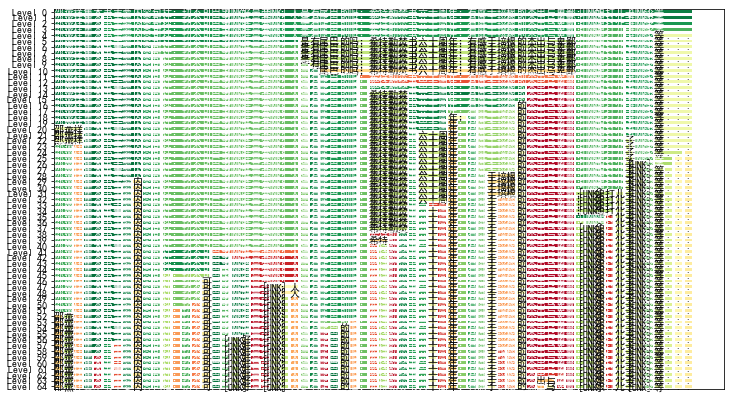

In [9]:
%matplotlib inline
shap.visualize_tree(inputs, tokenizer)